In [672]:
from tqdm import tqdm
import os
from os.path import join
import math
import shutil
from shutil import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(17)

In [673]:
dirs = ['test', 'train']

In [674]:
buff = os.listdir(dirs[1])

def getFilenames(path):
    out = []
    for dirpath, dirnames, filenames in os.walk(dirs[1]):
        dirpath = dirpath.replace('\\', '/')
        for file in filenames:
            if file.find('.jpg') > 0:
                out.append(f'{dirpath}/{file}')
    return out

if 'train' and 'val' in buff:
    shutil.rmtree(f'{dirs[1]}/train')
    shutil.rmtree(f'{dirs[1]}/val')
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')
else:
    print(buff)
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')

filenames = getFilenames(dirs[1])
for i, file in enumerate(filenames):
    if i % 5 == 0:
        name = 'cleaned' if 'cleaned' in file else 'dirty'
        copy(file, f'{dirs[1]}/val/{name}/{i}{name}.jpg')
    else:
        copy(file, f'{dirs[1]}/train/{name}/{i}{name}.jpg')

In [675]:
crop = 256
size = 224
transform = transforms.Compose([
#     transforms.CenterCrop([crop, crop]),
    transforms.Resize([size, size]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform1 = transforms.Compose([
#     transforms.CenterCrop([crop, crop]),
    transforms.Resize([size, size]),
#     transforms.RandomRotation(30),
#     transforms.RandomInvert(p=1),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform2 = transforms.Compose([
    transforms.CenterCrop([crop, crop]),
    transforms.Resize([size, size]),
#     transforms.RandomRotation(30),
#     transforms.RandomInvert(p=1),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform3 = transforms.Compose([
    transforms.CenterCrop([crop, crop]),
    transforms.Resize([size, size]),
    transforms.RandomRotation(30),
#     transforms.RandomInvert(p=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
trainData1 = ImageFolder('train/train', transform1)
trainData2 = ImageFolder('train/train', transform2)
trainData3 = ImageFolder('train/train', transform3)

In [689]:
trainPath = 'train/train'
valPath = 'train/val'

trainData = ImageFolder('train/train', transform1)
# trainData = torch.utils.data.ConcatDataset([trainData1, trainData2, trainData3])
valData = ImageFolder('train/val', transform)

batch_size = 8
num_workers = 0
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valLoader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=num_workers)

def imshow(model, loader):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    model.eval()
    x, y = next(iter(loader))
    pred = model(x)

    for i in range(len(x)):
        title = pred.argmax(dim=1).numpy()
        plt.imshow(x[i].permute(1,2,0).numpy()* std + mean)
        plt.title('dirty' if title[i] == 1 else 'cleaned')
        plt.show()
    
len(trainLoader)

4

In [682]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)
# model = models.vgg11(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
# model.fc = nn.Linear(model.fc.in_features, 2)
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Linear(model.fc.in_features, 2))

model.to(device)

loss = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(),amsgrad=True, lr=0.0001, weight_decay=1)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)

In [683]:
# lr_finder = LRFinder(model, optimizer, loss, 'cpu')
# lr_finder.range_test(trainLoader, val_loader=valLoader, end_lr=1.0, num_iter=100)
# lr_finder.plot()
# lr_finder.reset()

In [684]:
lossval = []
accval = []
losstrain = []
acctrain = []

def trainModel(model, loss, optimizer, scheduler, numEpochs):
    for epoch in range(numEpochs):
        print(f'epoch {epoch}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = trainLoader
                model.train()
            else:
                dataloader = valLoader
                model.eval()
                
            runningLoss = 0
            runningAcc = 0
            
            for inputs, labels in tqdm(dataloader):
                optimizer.zero_grad()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    lossValue = loss(preds, labels)
                    predsClass = preds.argmax(dim=1)
                    
                    if phase == 'train':
                        lossValue.backward()
                        optimizer.step()
                        
                runningLoss += lossValue.item()
                runningAcc += (predsClass.data == labels.data).float().mean()
                
            epochLoss = runningLoss / len(dataloader)
            epochAcc = runningAcc / len(dataloader)
            
            if phase == "val":
                scheduler.step()
                lossval.append(epochLoss)
                accval.append(epochAcc)
            else:
                losstrain.append(epochLoss)
                acctrain.append(epochAcc)
            
            print(f'{phase} loss {epochLoss}, acc {epochAcc}')
        
    return model

In [685]:
trainModel(model, loss, optimizer, scheduler, 50)

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


train loss 0.7057235985994339, acc 0.5


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


val loss 0.74745112657547, acc 0.5
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


train loss 0.603744313120842, acc 0.59375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


val loss 0.6858681440353394, acc 0.5
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


train loss 0.5122997537255287, acc 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


val loss 0.6454648375511169, acc 0.5
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


train loss 0.44155000895261765, acc 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val loss 0.6451717615127563, acc 0.5
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


train loss 0.4097106084227562, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


val loss 0.643317461013794, acc 0.5
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


train loss 0.3385777398943901, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


val loss 0.6588042378425598, acc 0.5
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


train loss 0.2726917490363121, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


val loss 0.6827206015586853, acc 0.5
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


train loss 0.31879357621073723, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val loss 0.7136435508728027, acc 0.5
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


train loss 0.3248758241534233, acc 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val loss 0.7231025695800781, acc 0.5
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


train loss 0.24165187776088715, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


val loss 0.7074549794197083, acc 0.5
epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


train loss 0.2331099547445774, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


val loss 0.6814221143722534, acc 0.5
epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


train loss 0.1518404223024845, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val loss 0.6822769045829773, acc 0.5
epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


train loss 0.20768971368670464, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val loss 0.7068013548851013, acc 0.5
epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


train loss 0.22789856046438217, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


val loss 0.7050468325614929, acc 0.5
epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


train loss 0.25090824253857136, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


val loss 0.7098737955093384, acc 0.5
epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


train loss 0.26495196111500263, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


val loss 0.7413840889930725, acc 0.5
epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


train loss 0.24904542788863182, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


val loss 0.7370074987411499, acc 0.5
epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


train loss 0.14000567235052586, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


val loss 0.7275829315185547, acc 0.5
epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


train loss 0.13781304843723774, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


val loss 0.7590975165367126, acc 0.5
epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


train loss 0.22083761356770992, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


val loss 0.7293279767036438, acc 0.5
epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


train loss 0.13895625062286854, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val loss 0.7392644286155701, acc 0.5
epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


train loss 0.17677893675863743, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


val loss 0.7181021571159363, acc 0.5
epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


train loss 0.12835124507546425, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


val loss 0.7220004796981812, acc 0.5
epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


train loss 0.12033158168196678, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val loss 0.7475190758705139, acc 0.5
epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


train loss 0.12618462555110455, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


val loss 0.7293168902397156, acc 0.5
epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


train loss 0.1730588935315609, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


val loss 0.7238225340843201, acc 0.5
epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


train loss 0.10840163379907608, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


val loss 0.7726407647132874, acc 0.5
epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


train loss 0.2067098319530487, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


val loss 0.7913960814476013, acc 0.5
epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


train loss 0.11125649698078632, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val loss 0.8205482959747314, acc 0.5
epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


train loss 0.13562484178692102, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


val loss 0.8220071792602539, acc 0.5
epoch 30


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


train loss 0.12595214322209358, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val loss 0.8388071656227112, acc 0.5
epoch 31


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


train loss 0.16016073152422905, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


val loss 0.8374766707420349, acc 0.5
epoch 32


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


train loss 0.18699055165052414, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


val loss 0.816027820110321, acc 0.5
epoch 33


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


train loss 0.12075312621891499, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val loss 0.8464339971542358, acc 0.5
epoch 34


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


train loss 0.23401598818600178, acc 0.875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val loss 0.845721960067749, acc 0.5
epoch 35


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


train loss 0.1470511555671692, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


val loss 0.8116397857666016, acc 0.5
epoch 36


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


train loss 0.05716423969715834, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


val loss 0.7905698418617249, acc 0.5
epoch 37


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


train loss 0.11326247453689575, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


val loss 0.7727786302566528, acc 0.5
epoch 38


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


train loss 0.13103710487484932, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


val loss 0.8022804856300354, acc 0.5
epoch 39


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


train loss 0.12420712877064943, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


val loss 0.8248291015625, acc 0.5
epoch 40


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


train loss 0.2313620988279581, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


val loss 0.8240793943405151, acc 0.5
epoch 41


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


train loss 0.15066621825098991, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


val loss 0.8327342867851257, acc 0.5
epoch 42


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


train loss 0.12530025001615286, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


val loss 0.8410836458206177, acc 0.5
epoch 43


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


train loss 0.17315300926566124, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


val loss 0.8958119750022888, acc 0.5
epoch 44


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


train loss 0.20503165759146214, acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


val loss 0.8874884247779846, acc 0.5
epoch 45


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


train loss 0.10071076825261116, acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


val loss 0.9034674763679504, acc 0.5
epoch 46


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


train loss 0.10435224883258343, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val loss 0.9272786378860474, acc 0.5
epoch 47


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


train loss 0.06715026311576366, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


val loss 0.8986009359359741, acc 0.5
epoch 48


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


train loss 0.09581883810460567, acc 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


val loss 0.9153125882148743, acc 0.5
epoch 49


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


train loss 0.1834522457793355, acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

val loss 0.9157232046127319, acc 0.5


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

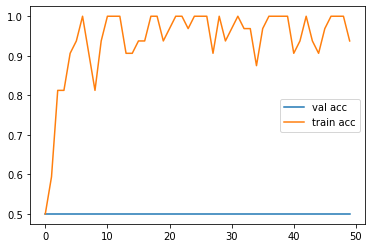

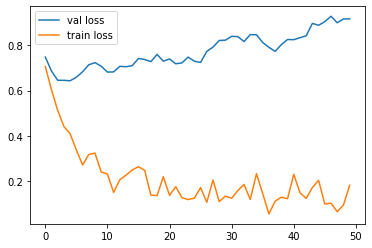

In [686]:
plt.plot(accval, label='val acc')
plt.plot(acctrain, label='train acc')
plt.legend()
plt.show()
plt.plot(lossval, label='val loss')
plt.plot(losstrain, label='train loss')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


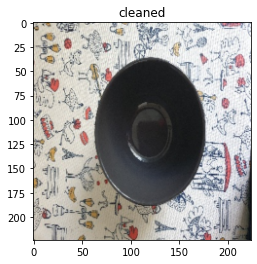

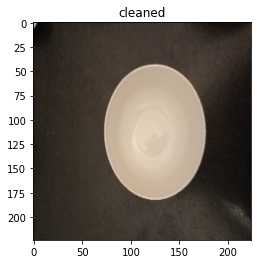

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


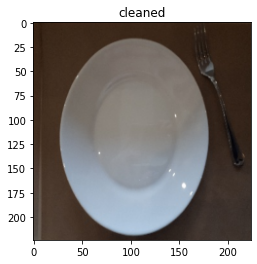

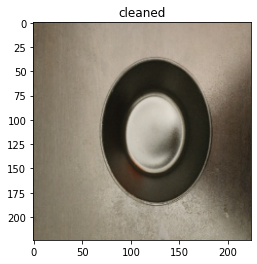

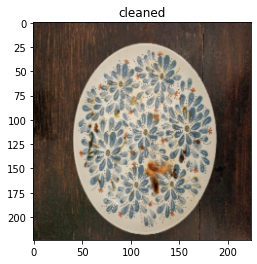

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


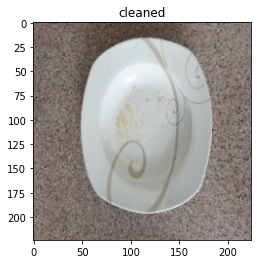

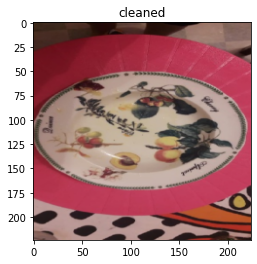

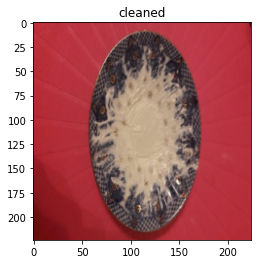

In [690]:
imshow(model, valLoader)